# Optimization problem with DAI as a target function
- Find optimal X to minimize or maximize  DAI-model(X)
- Baysian optimization using [GPyOpt](https://sheffieldml.github.io/GPyOpt/) ([API documentation](https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html))

In [31]:
from GPyOpt.methods import BayesianOptimization
import os
import functools
import driverlessai
print(driverlessai.__version__)
import pandas as pd
import numpy as np

1.10.1.3


## (Step1) Connect DAI and get an experiment to apply optimization.

In [2]:
# Connect DAI Server

import json
with open('../idpass.json') as f:
    idpass = json.load(f)

dai = driverlessai.Client(address='http://54.159.88.206:12345', username=idpass['id'], password=idpass['pass11013'])
dai

<class 'driverlessai._core.Client'> http://54.159.88.206:12345

In [3]:
# Experiment list
dai.experiments.list()

    | Type       | Key                                  | Name
----+------------+--------------------------------------+---------------------
  0 | Experiment | 575939ba-afc7-11ec-98cf-0242ac110002 | cc3-test
  1 | Experiment | 9b27f286-aca6-11ec-b964-0242ac110002 | uci-credit-reg-test
  2 | Experiment | bf5a9eba-9ea0-11ec-8908-0242ac110002 | dapawomu
  3 | Experiment | 69a5c178-9e9d-11ec-8908-0242ac110002 | bostonhouse-mod1
  4 | Experiment | 6dfccb46-9b86-11ec-8e63-0242ac110002 | wm-default

In [4]:
# Select experiment
experiment = dai.experiments.get(key='69a5c178-9e9d-11ec-8908-0242ac110002')
type(experiment)

driverlessai._experiments.Experiment

In [5]:
# Training data info
experiment.datasets

{'train_dataset': <class 'Dataset'> 653b25c2-91de-11ec-8bed-0242ac110002 BostonHousing.csv,
 'validation_dataset': None,
 'test_dataset': None}

This is BostonHousing dataset. ([Data Download](https://h2oai-jp-public.s3.ap-northeast-1.amazonaws.com/sample_data/boston_house/BostonHousing.csv))

## (Step2) Get training data info for optimization settings. 

In [6]:
dataset = dai.datasets.get(key=experiment.datasets['train_dataset'].key)
print('Training data: ', dataset)

data_cols = dataset.columns
print('Training data columns: ', data_cols)

try:
    drop_cols = experiment.settings['drop_columns']     # return dropped column in list
except KeyError:
    drop_cols = []     # if no dropped column
print('Dropped columns: ', drop_cols)

target_col = experiment.settings['target_column']
print('Target column used in the experiment: ', target_col)

x_cols = []
for col in data_cols:
    if (col in drop_cols) or (col in target_col):    # remove Target col and Dropped cols
        continue
    x_cols.append(col)
print('Features used in the experiment:  ', x_cols)       # We need this

Training data:  BostonHousing.csv (653b25c2-91de-11ec-8bed-0242ac110002)
Training data columns:  ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
Dropped columns:  []
Target column used in the experiment:  MEDV
Features used in the experiment:   ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [7]:
# Domain (Min and Max) of X columns and their types in training data

min_list = [col_summary.min for col_summary in dataset.column_summaries()[x_cols]]

max_list = [col_summary.max for col_summary in dataset.column_summaries()[x_cols]]

type_list = [col_summary.data_type for col_summary in dataset.column_summaries()[x_cols]]
type_list = pd.Series(type_list).map({'real':'continuous', 'int':'continupus', 'str':'categorical'})   # Map DAI data type to GPyOpt type
# GPyOpt takes 'continuous', 'discrete' or 'categorical'.
# 'categorical' is not tested in this notebook

df_domain = pd.DataFrame({'col':x_cols, 'min':min_list, 'max':max_list, 'type':type_list})

#df_domain['type'] = 'continuous'     # Column type. 'continuous' for continous optimization. 'discrite' for discrite optimization

df_domain

,col,min,max,type
0,CRIM,0.00632,88.9762,continuous
1,ZN,0.00000,100.0000,continuous
2,INDUS,0.46000,27.7400,continuous
3,CHAS,0.00000,1.0000,continuous
4,NOX,0.38500,0.8710,continuous
5,RM,3.56100,8.7800,continuous
6,AGE,2.90000,100.0000,continuous
7,DIS,1.12960,12.1265,continuous
8,RAD,1.00000,24.0000,continuous
9,TAX,187.00000,711.0000,continuous


GPyOpt supported input type
- https://gpyopt.readthedocs.io/en/latest/GPyOpt.core.task.html#GPyOpt.core.task.space.Design_space.supported_types

## (Step3) Baysian Optimization by GPyOpt

GPyOpt.methods.bayesian_optimization.BayesianOptimization
- Main class to initialize a Bayesian Optimization method
- https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html#GPyOpt.methods.bayesian_optimization.BayesianOptimization

In [94]:
def daimodel(x: np.array) -> np.array:
    ''' 
    This function does DAI Scoring. And we want to find optimal x to minimize or maximize daimodel(x)
    this function requires x_cols, dai(driverlessai._core.Client obj), and specified experiment(driverlessai._experiments.Experiment obj)
    Only regression model (classification model is not implemented)
    '''
    #print(type(x))
    #print(x.shape)
    #print(x)
    # Create a scoring data for DAI
    df = pd.DataFrame(np.array([x[:,i] for i in range(len(x_cols))]).reshape(x.shape[0], len(x_cols)), columns=x_cols)
    #print(df)
    # Upload it to DAI
    df.to_csv('tmp_pred.csv', index=False)
    data_to_predict = dai.datasets.create(data='./tmp_pred.csv', data_source='upload', name='tmp_pred.csv', force=True)
    # Scoring on the new dataset and download it
    dai_predictions = experiment.predict(dataset=data_to_predict, include_columns=data_to_predict.columns)
    data_to_predict.delete()
    # Download the scored data and return the prediction
    dai_predictions.download(dst_dir='', dst_file='tmp_res.csv', overwrite=True) 
    df_res = pd.read_csv('tmp_res.csv')
    print('---------- Done ----------')
    return np.array(df_res[experiment.settings['target_column']])    # return only prediction

In [17]:
# Example1

print('Input example: ', np.array([max_list]))
print('Imput data shape: ', np.array([max_list]).shape)

print('===== DAI Scoring =====')
daimodel(np.array([max_list]))

Input example:  [[ 88.9762 100.      27.74     1.       0.871    8.78   100.      12.1265
   24.     711.      22.     396.9     37.97  ]]
Imput data shape:  (1, 13)
===== DAI Scoring =====
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset e5f4ba04-ac9e-11ec-8a3a-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------


array([16.985456])

In [18]:
# Example2

daimodel(np.array([max_list, min_list]))

Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset f29e85f0-ac9e-11ec-8a3a-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------


array([ 7.4992714, 48.797626 ])

In [19]:
# Imput and its domain. Set the domain to be min and max of training data
bounds = [{'name':row['col'], 'type':row['type'], 'domain':(row['min'],row['max'])} for _, row in df_domain.iterrows()]
bounds

[{'name': 'CRIM', 'type': 'continuous', 'domain': (0.00632, 88.9762)},
 {'name': 'ZN', 'type': 'continuous', 'domain': (0.0, 100.0)},
 {'name': 'INDUS', 'type': 'continuous', 'domain': (0.46, 27.74)},
 {'name': 'CHAS', 'type': 'continuous', 'domain': (0.0, 1.0)},
 {'name': 'NOX', 'type': 'continuous', 'domain': (0.385, 0.871)},
 {'name': 'RM', 'type': 'continuous', 'domain': (3.561, 8.78)},
 {'name': 'AGE', 'type': 'continuous', 'domain': (2.9, 100.0)},
 {'name': 'DIS', 'type': 'continuous', 'domain': (1.1296, 12.1265)},
 {'name': 'RAD', 'type': 'continuous', 'domain': (1.0, 24.0)},
 {'name': 'TAX', 'type': 'continuous', 'domain': (187.0, 711.0)},
 {'name': 'PTRATIO', 'type': 'continuous', 'domain': (12.6, 22.0)},
 {'name': 'B', 'type': 'continuous', 'domain': (0.32, 396.9)},
 {'name': 'LSTAT', 'type': 'continuous', 'domain': (1.73, 37.97)}]

About input and its domain
- https://gpyopt.readthedocs.io/en/latest/GPyOpt.core.task.html#GPyOpt.core.task.space.Design_space

In [26]:
# run Baysian optimization
myBopt = BayesianOptimization(f=daimodel, 
                              domain=bounds, 
                              acquisition_type='EI',    # 'EI', 'MPI', 'LCB'
                              batch_size=1,
                              # ToDo: constraints. Can set constraints such as x1+x2+x3=1
                              constraints=None, 
                              maximize=True)  # maximize=True：maximization problem, that is to minimize -f

myBopt.run_optimization(max_iter=3, max_time=600)

Error in parallel computation. Fall back to single process!
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset a44c224e-ac9f-11ec-8a3a-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset a871b0e6-ac9f-11ec-8a3a-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset acafa604-ac9f-11ec-8a3a-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset b0f453ae-ac9f-11ec-8a3a-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset b53ad26c-ac9f-11ec-8a3a-0242

The first 5 runs are initial random guess. 

In [27]:
type(myBopt)

GPyOpt.methods.bayesian_optimization.BayesianOptimization

In [28]:
# Optimal x
myBopt.x_opt

array([ 58.35727058,  95.53708541,  10.47620174,   0.49424965,
         0.82457895,   7.20955646,  92.08470362,  10.18824491,
         6.67714106, 480.46328335,  13.43727608, 241.17541093,
         2.34203938])

In [29]:
pd.DataFrame(myBopt.x_opt.reshape(1,len(x_cols)), columns=x_cols)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,58.357271,95.537085,10.476202,0.49425,0.824579,7.209556,92.084704,10.188245,6.677141,480.463283,13.437276,241.175411,2.342039


In [30]:
# maxmized value of the target 
-1 * myBopt.fx_opt    # *-1 because we solved maxmization problem

41.469074

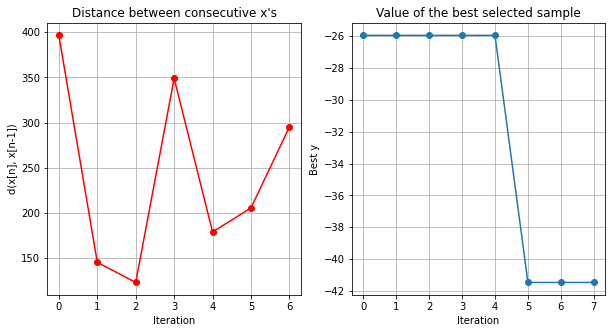

In [31]:
# Optimization history
myBopt.plot_convergence()

about plot
- https://gpyopt.readthedocs.io/en/latest/GPyOpt.core.html#GPyOpt.core.bo.BO.plot_convergence

In [55]:
# Scoring history

pd.DataFrame(myBopt.X, columns=x_cols).join(pd.DataFrame(myBopt.Y, columns=[target_col]))
# if maximization problem need *-1 for the target variable

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,13.264146,52.779628,16.226750,0.520632,0.571441,6.955624,3.775794,2.485824,5.147052,307.947453,13.537101,288.219975,13.806746,-25.942667
1,58.846367,50.523949,15.229437,0.215178,0.667682,4.678817,98.876912,2.977041,23.161956,683.720318,13.901318,353.363458,29.551094,-11.881808
2,64.143070,43.811011,13.650983,0.510994,0.659920,4.322187,69.837250,9.150506,17.070067,575.549413,21.422121,265.169681,5.125761,-24.796570
3,69.653087,40.506966,15.887719,0.880211,0.832448,6.734609,55.980910,2.894445,20.028125,670.199990,17.037085,340.684536,18.386182,-10.722339
4,71.939613,93.672700,26.812325,0.592520,0.591778,7.116636,53.381421,7.473544,21.495012,455.456437,19.855286,71.269044,19.776366,-19.526700
5,58.357271,95.537085,10.476202,0.494250,0.824579,7.209556,92.084704,10.188245,6.677141,480.463283,13.437276,241.175411,2.342039,-41.469074
6,10.226338,48.304727,17.612289,0.017178,0.859889,5.188705,5.669188,6.437028,9.902399,314.297725,12.954325,290.820022,11.039374,-19.595667
7,11.282442,1.993205,1.243632,0.009131,0.547865,7.768700,74.932779,3.109887,20.136803,585.373799,19.965922,368.300633,27.609811,-24.394072


## Crean up a flow of the processes

In [8]:
# DAI Parameters
dai_url = 'http://54.159.88.206:12345'
dai_uname = idpass['id']
dai_password = idpass['pass11013']
dai_experimet_key = '9b27f286-aca6-11ec-b964-0242ac110002'

# Optimization Parameters
acquisition_type = 'EI'    # 'EI', 'MPI', 'LCB'
constraints=None
maximize=False   # maximize=True：maximization problem, that is to minimize -f.  maximize=False：minimization problem
max_iter = 3
max_time = 600  # in seconds

In [9]:
dai = driverlessai.Client(address=dai_url, username=dai_uname, password=dai_password)

In [10]:
experiment = dai.experiments.get(key=dai_experimet_key)

## Column info
dataset = dai.datasets.get(key=experiment.datasets['train_dataset'].key)
data_cols = dataset.columns
try:
    drop_cols = experiment.settings['drop_columns']     # return dropped column in list
except KeyError:
    drop_cols = []     # if no dropped column
target_col = experiment.settings['target_column']
x_cols = []
for col in data_cols:
    if (col in drop_cols) or (col in target_col):    # remove Target col and Dropped cols
        continue
    x_cols.append(col)

## Domain (Min and Max) of X columns and their types in training data
min_list = [col_summary.min for col_summary in dataset.column_summaries()[x_cols]]
max_list = [col_summary.max for col_summary in dataset.column_summaries()[x_cols]]
type_list = [col_summary.data_type for col_summary in dataset.column_summaries()[x_cols]]
type_list = pd.Series(type_list).map({'real':'continuous', 'int':'continuous', 'str':'categorical'})   # Map DAI data type to GPyOpt type
# GPyOpt takes 'continuous', 'discrete' or 'categorical'.
# 'categorical' is not tested in this notebook
df_domain = pd.DataFrame({'col':x_cols, 'min':min_list, 'max':max_list, 'type':type_list})

In [32]:
def daimodel(x: np.array, dai: driverlessai._core.Client, experiment: driverlessai._experiments.Experiment) -> np.array:
    ''' 
    This function does DAI Scoring. And we want to find optimal x to minimize or maximize daimodel(x)
    Only regression model (classification model is not implemented)
    '''
    #print(type(x))
    #print(x.shape)
    #print(x)
    # Create a scoring data for DAI
    df = pd.DataFrame(np.array([x[:,i] for i in range(len(x_cols))]).reshape(x.shape[0], len(x_cols)), columns=x_cols)
    #print(df)
    # Upload it to DAI
    df.to_csv('tmp_pred.csv', index=False)
    data_to_predict = dai.datasets.create(data='./tmp_pred.csv', data_source='upload', name='tmp_pred.csv', force=True)
    # Scoring on the new dataset and download it
    dai_predictions = experiment.predict(dataset=data_to_predict, include_columns=data_to_predict.columns)
    data_to_predict.delete()
    # Download the scored data and return the prediction
    dai_predictions.download(dst_dir='', dst_file='tmp_res.csv', overwrite=True) 
    df_res = pd.read_csv('tmp_res.csv')
    print('---------- Done ----------')
    return np.array(df_res[experiment.settings['target_column']])    # return only prediction

daimodel_gpyopt = functools.partial(daimodel, dai=dai, experiment=experiment)

In [36]:
# Example
#daimodel_gpyopt(np.array([max_list]))

In [34]:
# Imput and its domain. Set the domain to be min and max of training data
bounds = [{'name':row['col'], 'type':row['type'], 'domain':(row['min'],row['max'])} for _, row in df_domain.iterrows()]

In [42]:
# run Baysian optimization
myBopt = BayesianOptimization(f=daimodel_gpyopt, 
                              domain=bounds, 
                              acquisition_type=acquisition_type,
                              #batch_size=4,
                              #num_cores=4,
                              # ToDo: constraints. Can set constraints such as x1+x2+x3=1
                              constraints=constraints, 
                              maximize=maximize)

myBopt.run_optimization(max_iter=max_iter, max_time=max_time)

Complete 100.00% - [4/4] Computed stats for column PAY_AMT6
Complete
Driverless AI Server reported dataset a55dea2a-b0ad-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column PAY_AMT6
Complete
Driverless AI Server reported dataset a98d09c8-b0ad-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column PAY_AMT6
Complete
Driverless AI Server reported dataset adb68344-b0ad-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column PAY_AMT6
Complete
Driverless AI Server reported dataset b1e0f684-b0ad-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column PAY_AMT6
Complete
Driverless AI Server reported dataset b63ab30a-b0ad-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
--

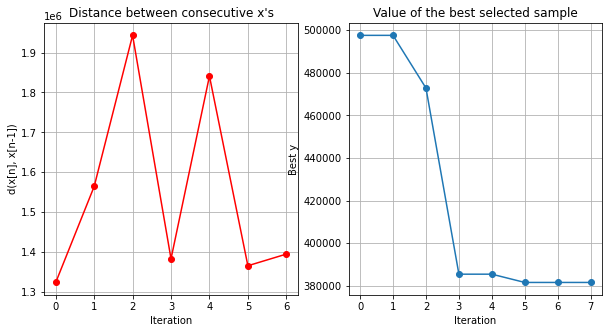

,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,LIMIT_BAL
0,1.019238,4.934877,1.339658,54.193982,5.582057,-1.839537,4.843442,6.477532,3.379727,4.664216,...,790607.331410,321212.369269,-15990.419418,466533.761389,9.634603e+05,61468.904766,8841.355813,191609.633697,182723.727407,497579.28
1,1.053903,4.303611,1.635582,39.213234,5.808196,4.252787,3.488627,7.929515,-0.746775,1.744049,...,745052.342822,184147.771731,840636.155056,730378.059981,6.653515e+05,256474.037843,572047.609690,103895.563879,326150.342670,590035.44
2,1.422327,3.175629,2.397555,22.354929,5.169809,1.399439,-0.379875,-1.431076,2.908537,1.299412,...,584294.751550,679389.421835,892054.577045,446934.796141,1.529912e+06,379549.312856,85763.513002,111753.841609,113257.793107,472835.34
3,1.542504,4.889235,0.681465,60.332693,3.067999,0.388822,5.862796,-0.326349,-0.249026,-1.246281,...,437756.160834,453897.690880,-127092.784614,8629.747007,3.075583e+05,346167.085879,588764.995691,60443.253076,523076.493669,385495.53
4,1.873856,1.704916,1.046521,57.862849,-0.177591,1.556163,3.803661,2.253720,0.157044,2.119375,...,-167757.099175,-30754.747313,28150.299859,643243.371526,1.414176e+05,51287.054678,387441.033007,323830.607901,284112.108350,495315.94
5,1.847199,2.119525,0.920856,38.658311,2.175229,3.389960,7.821414,3.998073,0.651858,7.497661,...,-102346.504026,639426.312681,28489.598529,390670.552191,1.319367e+06,684205.653756,495195.344734,352972.907793,107473.085614,381616.00
6,1.697058,0.496096,1.646792,39.949336,1.920426,3.562590,4.168339,-0.125488,0.745726,6.595687,...,377802.657303,451109.119088,525115.600006,321749.935042,1.010537e+06,532480.954139,111699.567678,352191.094574,204208.611482,515622.30
7,1.033989,5.529933,1.293629,40.133729,3.069244,7.805674,0.945194,3.165865,4.704218,-0.712914,...,-135237.807208,740877.401847,-209238.305738,124283.380949,5.484373e+05,238946.056726,599524.146745,140537.698876,316833.239806,498385.44


In [41]:
## results to be used 

# X
pd.DataFrame(myBopt.x_opt.reshape(1,len(x_cols)), columns=x_cols)
# y
myBopt.fx_opt
# Optimization history
myBopt.plot_convergence()
# Scoring history
pd.DataFrame(myBopt.X, columns=x_cols).join(pd.DataFrame(myBopt.Y, columns=[target_col]))

### To Do
- Handling categorical variable 
- Constraints
- Aiming a specific target value problem (not min or max problem)
- (?) Classification problem